In [60]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

## Training data

In [58]:
#demographic data

demographic_df = pd.read_csv('data/traindemographics.csv')

print(demographic_df.shape)

demographic_df.head(5)

(4346, 9)


,customerid,birthdate,bank_account_type,longitude_gps,latitude_gps,bank_name_clients,bank_branch_clients,employment_status_clients,level_of_education_clients
0,8a858e135cb22031015cbafc76964ebd,1973-10-10 00:00:00.000000,Savings,3.319219,6.528604,GT Bank,NaN,NaN,NaN
1,8a858e275c7ea5ec015c82482d7c3996,1986-01-21 00:00:00.000000,Savings,3.325598,7.119403,Sterling Bank,NaN,Permanent,NaN
2,8a858e5b5bd99460015bdc95cd485634,1987-04-01 00:00:00.000000,Savings,5.746100,5.563174,Fidelity Bank,NaN,NaN,NaN
3,8a858efd5ca70688015cabd1f1e94b55,1991-07-19 00:00:00.000000,Savings,3.362850,6.642485,GT Bank,NaN,Permanent,NaN
4,8a858e785acd3412015acd48f4920d04,1982-11-22 00:00:00.000000,Savings,8.455332,11.971410,GT Bank,NaN,Permanent,NaN


In [3]:
demographic_df['bank_account_type'].unique()

array(['Savings', 'Other', 'Current'], dtype=object)

In [4]:
demographic_df['bank_name_clients'].unique()

array(['GT Bank', 'Sterling Bank', 'Fidelity Bank', 'Access Bank',
       'EcoBank', 'FCMB', 'Skye Bank', 'UBA', 'Zenith Bank',
       'Diamond Bank', 'First Bank', 'Union Bank', 'Stanbic IBTC',
       'Standard Chartered', 'Heritage Bank', 'Keystone Bank',
       'Unity Bank', 'Wema Bank'], dtype=object)

In [5]:
demographic_df['employment_status_clients'].unique()

array([nan, 'Permanent', 'Student', 'Self-Employed', 'Unemployed',
       'Retired', 'Contract'], dtype=object)

In [6]:
demographic_df['level_of_education_clients'].unique()

array([nan, 'Secondary', 'Graduate', 'Post-Graduate', 'Primary'],
      dtype=object)

In [59]:
demographic_df.describe()

,longitude_gps,latitude_gps
count,4346.000000,4346.000000
mean,4.626189,7.251356
std,7.184832,3.055052
min,-118.247009,-33.868818
25%,3.354953,6.470610
50%,3.593302,6.621888
75%,6.545220,7.425052
max,151.209290,71.228069


In [69]:
#performance data

performance_df = pd.read_csv('data/trainperf.csv')

print(performance_df.shape)

performance_df.head(5)

(4368, 10)


,customerid,systemloanid,loannumber,approveddate,creationdate,loanamount,totaldue,termdays,referredby,good_bad_flag
0,8a2a81a74ce8c05d014cfb32a0da1049,301994762,12,2017-07-25 08:22:56.000000,2017-07-25 07:22:47.000000,30000.0,34500.0,30,NaN,Good
1,8a85886e54beabf90154c0a29ae757c0,301965204,2,2017-07-05 17:04:41.000000,2017-07-05 16:04:18.000000,15000.0,17250.0,30,NaN,Good
2,8a8588f35438fe12015444567666018e,301966580,7,2017-07-06 14:52:57.000000,2017-07-06 13:52:51.000000,20000.0,22250.0,15,NaN,Good
3,8a85890754145ace015429211b513e16,301999343,3,2017-07-27 19:00:41.000000,2017-07-27 18:00:35.000000,10000.0,11500.0,15,NaN,Good
4,8a858970548359cc0154883481981866,301962360,9,2017-07-03 23:42:45.000000,2017-07-03 22:42:39.000000,40000.0,44000.0,30,NaN,Good


In [9]:
performance_df['good_bad_flag'].unique()

array(['Good', 'Bad'], dtype=object)

C:\Users\Admin\AppData\Local\Temp\ipykernel_580\1118809601.py:47: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box_plot = axes[1, 1].boxplot(box_data, labels=['Good Loans', 'Bad Loans'],


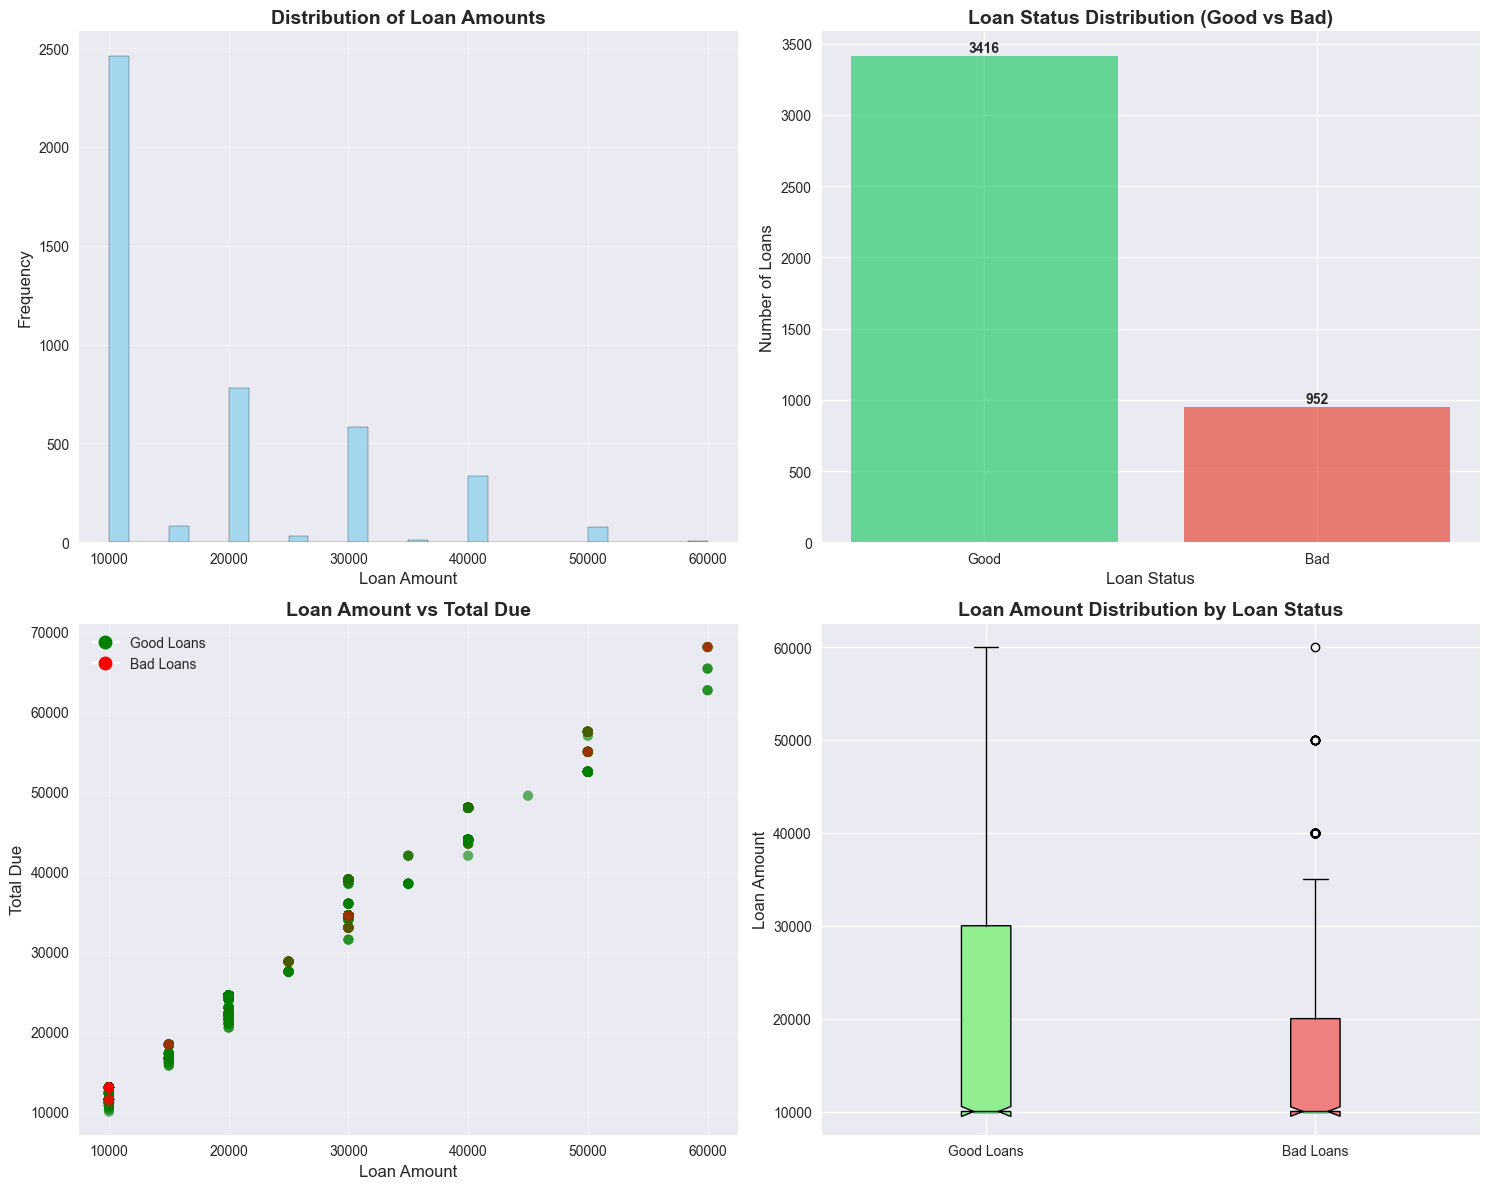

In [67]:
#create the plots
plt.style.use('seaborn-v0_8')
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

#histogram of Loan Amount
axes[0, 0].hist(performance_df['loanamount'], bins=30, color='skyblue', edgecolor='black', alpha=0.7)
axes[0, 0].set_title('Distribution of Loan Amounts', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Loan Amount', fontsize=12)
axes[0, 0].set_ylabel('Frequency', fontsize=12)
axes[0, 0].grid(True, alpha=0.3)

#bar chart of Good/Bad Loan Status Counts
status_counts = performance_df['good_bad_flag'].value_counts()
colors = ['#2ecc71', '#e74c3c'] 
bars = axes[0, 1].bar(status_counts.index, status_counts.values, color=colors, alpha=0.7)
axes[0, 1].set_title('Loan Status Distribution (Good vs Bad)', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Loan Status', fontsize=12)
axes[0, 1].set_ylabel('Number of Loans', fontsize=12)

#value labels on bars
for bar, count in zip(bars, status_counts.values):
    height = bar.get_height()
    axes[0, 1].text(bar.get_x() + bar.get_width()/2., height + 5,
                   f'{count}', ha='center', va='bottom', fontweight='bold')

#scatter plot of Loan Amount vs Total Due
colors = ['green' if status == 'Good' else 'red' for status in performance_df['good_bad_flag']]
scatter = axes[1, 0].scatter(performance_df['loanamount'], performance_df['totaldue'], c=colors, alpha=0.6)
axes[1, 0].set_title('Loan Amount vs Total Due', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Loan Amount', fontsize=12)
axes[1, 0].set_ylabel('Total Due', fontsize=12)
axes[1, 0].grid(True, alpha=0.3)

#legend for scatter plot
from matplotlib.lines import Line2D
legend_elements = [Line2D([0], [0], marker='o', color='w', markerfacecolor='green', 
                         markersize=10, label='Good Loans'),
                  Line2D([0], [0], marker='o', color='w', markerfacecolor='red', 
                         markersize=10, label='Bad Loans')]
axes[1, 0].legend(handles=legend_elements, loc='upper left')

#box plot of Loan Amount by Status
good_loans = performance_df[performance_df['good_bad_flag'] == 'Good']['loanamount']
bad_loans = performance_df[performance_df['good_bad_flag'] == 'Bad']['loanamount']

box_data = [good_loans, bad_loans]
box_plot = axes[1, 1].boxplot(box_data, labels=['Good Loans', 'Bad Loans'], 
                            patch_artist=True, notch=True)
axes[1, 1].set_title('Loan Amount Distribution by Loan Status', fontsize=14, fontweight='bold')
axes[1, 1].set_ylabel('Loan Amount', fontsize=12)

# colour the boxes
colors = ['lightgreen', 'lightcoral']
for patch, color in zip(box_plot['boxes'], colors):
    patch.set_facecolor(color)

plt.tight_layout()
plt.show()

In [68]:
#previous loans data

previous_loans_df = pd.read_csv('data/trainprevloans.csv')

print(previous_loans_df.shape)

previous_loans_df.head(5)

(18183, 12)


,customerid,systemloanid,loannumber,approveddate,creationdate,loanamount,totaldue,termdays,closeddate,referredby,firstduedate,firstrepaiddate
0,8a2a81a74ce8c05d014cfb32a0da1049,301682320,2,2016-08-15 18:22:40.000000,2016-08-15 17:22:32.000000,10000.0,13000.0,30,2016-09-01 16:06:48.000000,NaN,2016-09-14 00:00:00.000000,2016-09-01 15:51:43.000000
1,8a2a81a74ce8c05d014cfb32a0da1049,301883808,9,2017-04-28 18:39:07.000000,2017-04-28 17:38:53.000000,10000.0,13000.0,30,2017-05-28 14:44:49.000000,NaN,2017-05-30 00:00:00.000000,2017-05-26 00:00:00.000000
2,8a2a81a74ce8c05d014cfb32a0da1049,301831714,8,2017-03-05 10:56:25.000000,2017-03-05 09:56:19.000000,20000.0,23800.0,30,2017-04-26 22:18:56.000000,NaN,2017-04-04 00:00:00.000000,2017-04-26 22:03:47.000000
3,8a8588f35438fe12015444567666018e,301861541,5,2017-04-09 18:25:55.000000,2017-04-09 17:25:42.000000,10000.0,11500.0,15,2017-04-24 01:35:52.000000,NaN,2017-04-24 00:00:00.000000,2017-04-24 00:48:43.000000
4,8a85890754145ace015429211b513e16,301941754,2,2017-06-17 09:29:57.000000,2017-06-17 08:29:50.000000,10000.0,11500.0,15,2017-07-14 21:18:43.000000,NaN,2017-07-03 00:00:00.000000,2017-07-14 21:08:35.000000


In [11]:
previous_loans_df['customerid'].unique().shape

(4359,)

In [12]:
customer_counts = previous_loans_df['customerid'].value_counts()

most_frequent_customer = customer_counts.index[0]
count = customer_counts.iloc[0]

print(count)

26


In [13]:
#create new column for total number of previous loans

num_prev_loans_df = customer_counts.reset_index()

num_prev_loans_df.columns = ['customerid', 'number_of_prev_loans']

num_prev_loans_df.head()

,customerid,number_of_prev_loans
0,8a858f7d5578012a01557ea194d94948,26
1,8a858e4456ced8470156d73452f85335,22
2,8a85886f54517ee0015470749d3c3ce7,21
3,8a858fa5552add5d0155536bd49343f9,21
4,8a85888c548fb3d50154947fe59c32cf,21


In [14]:
#join the dataframes

merged_step1 = pd.merge(demographic_df, performance_df, on='customerid', how='outer')

print(merged_step1.shape)

merged_step1.head()

(5445, 18)


,customerid,birthdate,bank_account_type,longitude_gps,latitude_gps,bank_name_clients,bank_branch_clients,employment_status_clients,level_of_education_clients,systemloanid,loannumber,approveddate,creationdate,loanamount,totaldue,termdays,referredby,good_bad_flag
0,8a1088a0484472eb01484669e3ce4e0b,1989-11-09 00:00:00.000000,Savings,3.351667,6.657019,GT Bank,OJUELEGBA,Permanent,Primary,301999397.0,2.0,2017-07-27 19:44:08.000000,2017-07-27 18:44:00.000000,10000.0,11500.0,15.0,NaN,Bad
1,8a1a1e7e4f707f8b014f797718316cad,1979-10-18 00:00:00.000000,Other,3.395230,6.592192,Standard Chartered,NaN,Permanent,Graduate,301997672.0,5.0,2017-07-26 20:01:54.000000,2017-07-26 19:01:46.000000,30000.0,39000.0,60.0,NaN,Good
2,8a1a32fc49b632520149c3b8fdf85139,1979-01-29 00:00:00.000000,Savings,3.306388,6.651843,GT Bank,MUSHIN BRANCH,Permanent,Graduate,301976551.0,8.0,2017-07-13 19:22:15.000000,2017-07-13 18:22:05.000000,20000.0,24500.0,30.0,NaN,Good
3,8a1eb5ba49a682300149c3c068b806c7,1978-11-25 00:00:00.000000,Savings,3.426698,6.423048,First Bank,"17, SANUSI FAFUNWA STREET, VICTORIA ISLAND, LAGOS",Permanent,Secondary,301975382.0,9.0,2017-07-13 00:34:03.000000,2017-07-12 23:33:54.000000,30000.0,39000.0,60.0,NaN,Good
4,8a1edbf14734127f0147356fdb1b1eb2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,301979352.0,3.0,2017-07-15 16:02:04.000000,2017-07-15 15:01:56.000000,10000.0,11500.0,15.0,NaN,Good


In [15]:
# ids_demographic_df = set(demographic_df['customerid'])
# ids_performance_df = set(performance_df['customerid'])

# only_in_demographic_df = ids_demographic_df - ids_performance_df
# only_in_performance_df = ids_performance_df - ids_demographic_df

# only_in_demographic_df, only_in_performance_df

In [16]:
merged_step2 = pd.merge(merged_step1, num_prev_loans_df, on='customerid', how='outer')

print(merged_step2.shape)

merged_step2.head()

(5445, 19)


,customerid,birthdate,bank_account_type,longitude_gps,latitude_gps,bank_name_clients,bank_branch_clients,employment_status_clients,level_of_education_clients,systemloanid,loannumber,approveddate,creationdate,loanamount,totaldue,termdays,referredby,good_bad_flag,number_of_prev_loans
0,8a1088a0484472eb01484669e3ce4e0b,1989-11-09 00:00:00.000000,Savings,3.351667,6.657019,GT Bank,OJUELEGBA,Permanent,Primary,301999397.0,2.0,2017-07-27 19:44:08.000000,2017-07-27 18:44:00.000000,10000.0,11500.0,15.0,NaN,Bad,1.0
1,8a1a1e7e4f707f8b014f797718316cad,1979-10-18 00:00:00.000000,Other,3.395230,6.592192,Standard Chartered,NaN,Permanent,Graduate,301997672.0,5.0,2017-07-26 20:01:54.000000,2017-07-26 19:01:46.000000,30000.0,39000.0,60.0,NaN,Good,4.0
2,8a1a32fc49b632520149c3b8fdf85139,1979-01-29 00:00:00.000000,Savings,3.306388,6.651843,GT Bank,MUSHIN BRANCH,Permanent,Graduate,301976551.0,8.0,2017-07-13 19:22:15.000000,2017-07-13 18:22:05.000000,20000.0,24500.0,30.0,NaN,Good,7.0
3,8a1eb5ba49a682300149c3c068b806c7,1978-11-25 00:00:00.000000,Savings,3.426698,6.423048,First Bank,"17, SANUSI FAFUNWA STREET, VICTORIA ISLAND, LAGOS",Permanent,Secondary,301975382.0,9.0,2017-07-13 00:34:03.000000,2017-07-12 23:33:54.000000,30000.0,39000.0,60.0,NaN,Good,8.0
4,8a1edbf14734127f0147356fdb1b1eb2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,301979352.0,3.0,2017-07-15 16:02:04.000000,2017-07-15 15:01:56.000000,10000.0,11500.0,15.0,NaN,Good,2.0


In [17]:
cleaned_merged_df = merged_step2.dropna(subset=['good_bad_flag'])

cleaned_merged_df.shape

(4376, 19)

In [18]:
drop_columns = ['customerid', 'birthdate', 'bank_branch_clients', 'systemloanid', 'approveddate', 'creationdate', 'referredby', 'loannumber'] 

final_df = cleaned_merged_df.drop(columns=drop_columns)

print(final_df.shape)

final_df.head()

final_df.to_csv('final_df.csv', index=False)

(4376, 11)


In [19]:
categorical_columns = ['bank_account_type', 'bank_name_clients', 'employment_status_clients', 'level_of_education_clients', 'good_bad_flag']

for col in categorical_columns:
    print(final_df[col].unique(), '\n======\n')
          

['Savings' 'Other' nan 'Current'] 

['GT Bank' 'Standard Chartered' 'First Bank' nan 'Access Bank'
 'Diamond Bank' 'EcoBank' 'Stanbic IBTC' 'Sterling Bank' 'Skye Bank' 'UBA'
 'Zenith Bank' 'FCMB' 'Fidelity Bank' 'Wema Bank' 'Union Bank'
 'Keystone Bank' 'Heritage Bank' 'Unity Bank'] 

['Permanent' nan 'Self-Employed' 'Retired' 'Student' 'Unemployed'
 'Contract'] 

['Primary' 'Graduate' 'Secondary' nan 'Post-Graduate'] 

['Bad' 'Good'] 



In [20]:
account_map = {'Savings': 1, 'Other':2, np.nan: 0, 'Current':3}

bank_name_map = {'GT Bank': 1, 'Standard Chartered': 2, 'First Bank': 3, np.nan: 0, 'Access Bank': 4,
 'Diamond Bank': 5, 'EcoBank': 6, 'Stanbic IBTC': 7, 'Sterling Bank': 8, 'Skye Bank': 9, 'UBA': 10,
 'Zenith Bank': 11, 'FCMB': 12, 'Fidelity Bank': 13, 'Wema Bank': 14, 'Union Bank': 15,
 'Keystone Bank': 16, 'Heritage Bank': 17, 'Unity Bank': 18 }

employment_map = {'Permanent': 1, np.nan: 0, 'Self-Employed': 2, 'Retired': 3, 'Student': 4, 'Unemployed': 5,
 'Contract': 6}

education_map = {'Primary': 1, 'Graduate': 2, 'Secondary': 3, np.nan: 0, 'Post-Graduate': 4}

flag_map = {'Bad': 0, 'Good': 1}

##[, '', '', '', '']


final_df['bank_account_type_encoded'] = final_df['bank_account_type'].map(account_map)
final_df['bank_name_clients_encoded'] = final_df['bank_name_clients'].map(bank_name_map)
final_df['employment_status_clients_encoded'] = final_df['employment_status_clients'].map(employment_map)
final_df['level_of_education_clients_encoded'] = final_df['level_of_education_clients'].map(education_map)
final_df['good_bad_flag_encoded'] = final_df['good_bad_flag'].map(flag_map)

final_df.head()

,bank_account_type,longitude_gps,latitude_gps,bank_name_clients,employment_status_clients,level_of_education_clients,loanamount,totaldue,termdays,good_bad_flag,number_of_prev_loans,bank_account_type_encoded,bank_name_clients_encoded,employment_status_clients_encoded,level_of_education_clients_encoded,good_bad_flag_encoded
0,Savings,3.351667,6.657019,GT Bank,Permanent,Primary,10000.0,11500.0,15.0,Bad,1.0,1,1,1,1,0
1,Other,3.395230,6.592192,Standard Chartered,Permanent,Graduate,30000.0,39000.0,60.0,Good,4.0,2,2,1,2,1
2,Savings,3.306388,6.651843,GT Bank,Permanent,Graduate,20000.0,24500.0,30.0,Good,7.0,1,1,1,2,1
3,Savings,3.426698,6.423048,First Bank,Permanent,Secondary,30000.0,39000.0,60.0,Good,8.0,1,3,1,3,1
4,NaN,NaN,NaN,NaN,NaN,NaN,10000.0,11500.0,15.0,Good,2.0,0,0,0,0,1


In [21]:
encoded_df = final_df.drop(columns=categorical_columns)

encoded_df.head()

,longitude_gps,latitude_gps,loanamount,totaldue,termdays,number_of_prev_loans,bank_account_type_encoded,bank_name_clients_encoded,employment_status_clients_encoded,level_of_education_clients_encoded,good_bad_flag_encoded
0,3.351667,6.657019,10000.0,11500.0,15.0,1.0,1,1,1,1,0
1,3.395230,6.592192,30000.0,39000.0,60.0,4.0,2,2,1,2,1
2,3.306388,6.651843,20000.0,24500.0,30.0,7.0,1,1,1,2,1
3,3.426698,6.423048,30000.0,39000.0,60.0,8.0,1,3,1,3,1
4,NaN,NaN,10000.0,11500.0,15.0,2.0,0,0,0,0,1


In [70]:
#load data
df = pd.read_csv("final_df.csv")

#define column groups
categorical_cols = [
    'bank_account_type',
    'bank_name_clients',
    'employment_status_clients',
    'level_of_education_clients'
]

numeric_cols = [
    'longitude_gps',
    'latitude_gps',
    'loanamount',
    'totaldue',
    'termdays',
    'number_of_prev_loans'
]

# fill missing values
#fill categorical NaN with "Unknown"
for col in categorical_cols:
    df[col] = df[col].fillna("Unknown")

#fill numeric NaN with median
for col in numeric_cols:
    df[col] = df[col].fillna(df[col].median())

#manual encoding ensuring "Unknown" = 0
for col in categorical_cols:
    unique_vals = sorted(df[col].dropna().unique())
    if "Unknown" in unique_vals:
        unique_vals.remove("Unknown")
    mapping = {"Unknown": 0}
    mapping.update({val: i + 1 for i, val in enumerate(unique_vals)})
    df[col + "_encoded"] = df[col].map(mapping)

#encode target variable
# Ensure "Good"=1 (non-defaulter), "Bad"=0 (defaulter)
df["good_bad_flag_encoded"] = df["good_bad_flag"].map({"Good": 1, "Bad": 0})

#region clustering from GPS
gps_df = df[["longitude_gps", "latitude_gps"]].copy()

#automatically find best k (2–10) using silhouette score
inertias, silhouette_scores = [], []
K = range(2, 10)

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(gps_df)
    inertias.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(gps_df, labels))

best_k = K[np.argmax(silhouette_scores)]

#apply final clustering
kmeans_final = KMeans(n_clusters=best_k, random_state=42)
df["region_cluster"] = kmeans_final.fit_predict(gps_df)

#drop raw string columns
df_encoded = df.drop(columns=categorical_cols + ["good_bad_flag"])

#save encoded DataFrame
#df_encoded.to_csv("final_encoded_df.csv", index=False)


df_encoded.head()


,longitude_gps,latitude_gps,loanamount,totaldue,termdays,number_of_prev_loans,bank_account_type_encoded,bank_name_clients_encoded,employment_status_clients_encoded,level_of_education_clients_encoded,good_bad_flag_encoded,region_cluster
0,3.351667,6.657019,10000.0,11500.0,15.0,1.0,3,7,2,3,0,0
1,3.395230,6.592192,30000.0,39000.0,60.0,4.0,2,12,2,1,1,0
2,3.306388,6.651843,20000.0,24500.0,30.0,7.0,3,7,2,1,1,0
3,3.426698,6.423048,30000.0,39000.0,60.0,8.0,3,6,2,4,1,0
4,3.587546,6.625954,10000.0,11500.0,15.0,2.0,0,0,0,0,1,0


In [71]:
#define features (X) and target (y)
X = df_encoded[
    [
        "longitude_gps",
        "latitude_gps",
        "region_cluster",
        "loanamount",
        "totaldue",
        "termdays",
        "number_of_prev_loans",
        "bank_account_type_encoded",
        "bank_name_clients_encoded",
        "employment_status_clients_encoded",
        "level_of_education_clients_encoded"
    ]
]
y = df_encoded["good_bad_flag_encoded"]

#train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# initialise XGBoost model
xgb_model = XGBClassifier(
    n_estimators=400,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    scale_pos_weight=(y.value_counts()[0] / y.value_counts()[1]),
    random_state=42,
    eval_metric='auc',
    use_label_encoder=False
)

#train the model
xgb_model.fit(X_train, y_train)

#evaluate the model
y_pred = xgb_model.predict(X_test)
y_prob = xgb_model.predict_proba(X_test)[:, 1]

print(confusion_matrix(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))
print(f"ROC-AUC Score: {roc_auc_score(y_test, y_prob):.4f}")

#feature importance
importances = pd.Series(xgb_model.feature_importances_, index=X.columns).sort_values(ascending=False)
print("\nFeature Importances:")
print(importances)


C:\Users\Admin\basic-env\Lib\site-packages\xgboost\training.py:183: UserWarning: [23:33:19] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[[ 86 105]
 [235 450]]

Classification Report:
              precision    recall  f1-score   support

           0       0.27      0.45      0.34       191
           1       0.81      0.66      0.73       685

    accuracy                           0.61       876
   macro avg       0.54      0.55      0.53       876
weighted avg       0.69      0.61      0.64       876

ROC-AUC Score: 0.5780

Feature Importances:
termdays                              0.123268
loanamount                            0.122933
totaldue                              0.112710
bank_account_type_encoded             0.104130
employment_status_clients_encoded     0.099457
latitude_gps                          0.096023
longitude_gps                         0.090965
bank_name_clients_encoded             0.085587
number_of_prev_loans                  0.085162
level_of_education_clients_encoded    0.079766
region_cluster                        0.000000
dtype: float32


## Model Testing

In [28]:
test_demographics_df = pd.read_csv('data/testdemographics.csv')

print(test_demographics_df.shape)

test_demographics_df.head()

(1487, 9)


,customerid,birthdate,bank_account_type,longitude_gps,latitude_gps,bank_name_clients,bank_branch_clients,employment_status_clients,level_of_education_clients
0,8a858f305c8dd672015c93b1db645db4,1976-08-28 00:00:00.000000,Savings,5.296628,7.593965,Heritage Bank,NaN,Permanent,NaN
1,8a858f085a477386015a47fb049e49ca,1978-06-23 00:00:00.000000,Savings,3.294513,6.596602,UBA,NaN,Permanent,NaN
2,8a858e6f5cd5e874015cd6f5634c39ad,1984-04-04 00:00:00.000000,Savings,8.501912,7.729364,First Bank,NaN,Permanent,NaN
3,8a858e9d5bfd7037015bfdab79f61305,1983-05-28 00:00:00.000000,Savings,3.318904,6.681595,UBA,NaN,Permanent,NaN
4,8a858fde56eb02280156eb6dafc128ac,1982-03-29 00:00:00.000000,Savings,6.354624,4.949031,First Bank,NaN,Self-Employed,NaN


In [29]:
test_performance_df = pd.read_csv('data/testperf.csv')

print(test_performance_df.shape)

test_performance_df.head()

(1450, 9)


,customerid,systemloanid,loannumber,approveddate,creationdate,loanamount,totaldue,termdays,referredby
0,8a858899538ddb8e015390510b321f08,301998974,4,40:48.0,39:35.0,10000,12250.0,30,NaN
1,8a858959537a097401537a4e316e25f7,301963615,10,43:40.0,42:34.0,40000,44000.0,30,NaN
2,8a8589c253ace09b0153af6ba58f1f31,301982236,6,15:11.0,15:04.0,20000,24500.0,30,NaN
3,8a858e095aae82b7015aae86ca1e030b,301971730,8,00:54.0,00:49.0,30000,34500.0,30,NaN
4,8a858e225a28c713015a30db5c48383d,301959177,4,04:33.0,04:27.0,20000,24500.0,30,NaN


In [30]:
test_previous_df = pd.read_csv('data/testprevloans.csv')

print(test_previous_df.shape)

test_previous_df.head()

(5907, 12)


,customerid,systemloanid,loannumber,approveddate,creationdate,loanamount,totaldue,termdays,closeddate,referredby,firstduedate,firstrepaiddate
0,8a858899538ddb8e015390510b321f08,301621635,3,2016-05-17 10:37:00.000000,2016-05-17 09:36:55.000000,10000.0,13000.0,30,2016-06-17 00:04:15.000000,NaN,2016-06-16 00:00:00.000000,2016-06-16 15:44:08.000000
1,8a858959537a097401537a4e316e25f7,301810201,5,2017-02-04 21:28:59.000000,2017-02-04 20:28:52.000000,30000.0,36800.0,60,2017-03-02 16:22:58.000000,NaN,2017-03-06 00:00:00.000000,2017-03-02 16:07:47.000000
2,8a858959537a097401537a4e316e25f7,301831255,6,2017-03-04 10:28:22.000000,2017-03-04 09:28:16.000000,30000.0,34400.0,30,2017-04-02 00:44:24.000000,NaN,2017-04-03 00:00:00.000000,2017-04-01 21:29:46.000000
3,8a8589c253ace09b0153af6ba58f1f31,301627292,3,2016-06-02 14:27:14.000000,2016-06-02 13:27:08.000000,10000.0,13000.0,30,2016-07-04 11:34:04.000000,NaN,2016-07-04 00:00:00.000000,2016-07-04 11:19:01.000000
4,8a8589c253ace09b0153af6ba58f1f31,301621095,2,2016-05-16 09:13:12.000000,2016-05-16 08:13:04.000000,10000.0,11500.0,15,2016-06-02 00:02:58.000000,NaN,2016-05-31 00:00:00.000000,2016-06-01 15:22:34.000000


In [31]:
customer_counts = test_previous_df['customerid'].value_counts()

most_frequent_customer = customer_counts.index[0]
count = customer_counts.iloc[0]

print(count)

test_num_prev_loans_df = customer_counts.reset_index()

test_num_prev_loans_df.columns = ['customerid', 'number_of_prev_loans']

print(test_num_prev_loans_df.shape)

test_num_prev_loans_df.head()

33
(1442, 2)


,customerid,number_of_prev_loans
0,8a858ff554e290e10154fe4e6b3f648c,33
1,8a858fdd54d4dd160154e1edcb6d7596,20
2,8a858f1554e29449015505ceef786df0,18
3,8a8588d653a915270153ab10232e304f,18
4,8a858966538deb190153957484683e67,17


In [32]:
#join the dataframes

test_merged_step1 = pd.merge(test_demographics_df, test_performance_df, on='customerid', how='outer')

print(test_merged_step1.shape)

test_merged_step1.head()




(2552, 17)


,customerid,birthdate,bank_account_type,longitude_gps,latitude_gps,bank_name_clients,bank_branch_clients,employment_status_clients,level_of_education_clients,systemloanid,loannumber,approveddate,creationdate,loanamount,totaldue,termdays,referredby
0,8a1edbf14734127f0147356fdb1b1eb2,1978-04-07 00:00:00.000000,Savings,6.976132,4.801001,GT Bank,"AKUTE,LAGOS.",Permanent,Secondary,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,8a28afc7474813a40147639ec637156b,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,301997111.0,11.0,40:55.0,39:44.0,25000.0,27500.0,30.0,NaN
2,8a2ac4745091002b0150a144bcbe58b7,1986-02-06 00:00:00.000000,Other,8.569183,11.975772,GT Bank,NaN,Permanent,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,8a3735d5518aba7301518ac34413010d,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,301968180.0,7.0,50:27.0,50:22.0,20000.0,24500.0,30.0,NaN
4,8a390a2150ad97330150aebdd8ef7456,1988-10-01 00:00:00.000000,Savings,7.037345,4.818978,Access Bank,NaN,Permanent,Graduate,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [33]:
test_merged_step2 = pd.merge(test_merged_step1, test_num_prev_loans_df, on='customerid', how='outer')

print(test_merged_step2.shape)

test_merged_step2.head()

(2552, 18)


,customerid,birthdate,bank_account_type,longitude_gps,latitude_gps,bank_name_clients,bank_branch_clients,employment_status_clients,level_of_education_clients,systemloanid,loannumber,approveddate,creationdate,loanamount,totaldue,termdays,referredby,number_of_prev_loans
0,8a1edbf14734127f0147356fdb1b1eb2,1978-04-07 00:00:00.000000,Savings,6.976132,4.801001,GT Bank,"AKUTE,LAGOS.",Permanent,Secondary,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,8a28afc7474813a40147639ec637156b,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,301997111.0,11.0,40:55.0,39:44.0,25000.0,27500.0,30.0,NaN,10.0
2,8a2ac4745091002b0150a144bcbe58b7,1986-02-06 00:00:00.000000,Other,8.569183,11.975772,GT Bank,NaN,Permanent,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,8a3735d5518aba7301518ac34413010d,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,301968180.0,7.0,50:27.0,50:22.0,20000.0,24500.0,30.0,NaN,6.0
4,8a390a2150ad97330150aebdd8ef7456,1988-10-01 00:00:00.000000,Savings,7.037345,4.818978,Access Bank,NaN,Permanent,Graduate,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [38]:
drop_columns = ['birthdate', 'bank_branch_clients', 'systemloanid', 'approveddate', 'creationdate', 'referredby', 'loannumber'] 

test_final_df = test_merged_step2.drop(columns=drop_columns)

print(test_final_df.shape)

test_final_df.head()

test_final_df.to_csv('test_final_df.csv', index=False)

(2552, 11)


In [41]:
# Load data
df = pd.read_csv("test_final_df.csv")

#define column groups
categorical_cols = [
    'bank_account_type',
    'bank_name_clients',
    'employment_status_clients',
    'level_of_education_clients'
]

numeric_cols = [
    'longitude_gps',
    'latitude_gps',
    'loanamount',
    'totaldue',
    'termdays',
    'number_of_prev_loans'
]

#fill missing values
#fill categorical NaN with "Unknown"
for col in categorical_cols:
    df[col] = df[col].fillna("Unknown")

#fill numeric NaN with median
for col in numeric_cols:
    df[col] = df[col].fillna(df[col].median())

#manual encoding ensuring "Unknown" = 0
for col in categorical_cols:
    unique_vals = sorted(df[col].dropna().unique())
    if "Unknown" in unique_vals:
        unique_vals.remove("Unknown")
    mapping = {"Unknown": 0}
    mapping.update({val: i + 1 for i, val in enumerate(unique_vals)})
    df[col + "_encoded"] = df[col].map(mapping)

#region clustering from GPS
gps_df = df[["longitude_gps", "latitude_gps"]].copy()

#automatically find best k (2–10) using silhouette score
inertias, silhouette_scores = [], []
K = range(2, 10)

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(gps_df)
    inertias.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(gps_df, labels))

best_k = K[np.argmax(silhouette_scores)]

#apply final clustering
kmeans_final = KMeans(n_clusters=best_k, random_state=42)
df["region_cluster"] = kmeans_final.fit_predict(gps_df)

#drop raw string columns
test_df_encoded = df.drop(columns=categorical_cols)

#save encoded DataFrame
#df_encoded.to_csv("final_encoded_df.csv", index=False)

test_df_encoded.head()


✅ Optimal number of clusters (k): 9
✅ Encoded DataFrame saved as 'final_encoded_df.csv'


,customerid,longitude_gps,latitude_gps,loanamount,totaldue,termdays,number_of_prev_loans,bank_account_type_encoded,bank_name_clients_encoded,employment_status_clients_encoded,level_of_education_clients_encoded,region_cluster
0,8a1edbf14734127f0147356fdb1b1eb2,6.976132,4.801001,10000.0,13000.0,30.0,3.0,3,7,2,4,0
1,8a28afc7474813a40147639ec637156b,3.583009,6.620080,25000.0,27500.0,30.0,10.0,0,0,0,0,1
2,8a2ac4745091002b0150a144bcbe58b7,8.569183,11.975772,10000.0,13000.0,30.0,3.0,2,7,2,0,4
3,8a3735d5518aba7301518ac34413010d,3.583009,6.620080,20000.0,24500.0,30.0,6.0,0,0,0,0,1
4,8a390a2150ad97330150aebdd8ef7456,7.037345,4.818978,10000.0,13000.0,30.0,3.0,3,1,2,1,0


In [42]:
#keep customerID for the final output
customer_ids = test_df_encoded["customerid"]

# Replace NaNs with 0 (as per your requirement)
test_df_encoded = test_df_encoded.fillna(0)

In [72]:
#match the exact feature columns used during training
X_test_xgb = test_df_encoded[
    [
        "longitude_gps",
        "latitude_gps",
        "region_cluster",
        "loanamount",
        "totaldue",
        "termdays",
        "number_of_prev_loans",
        "bank_account_type_encoded",
        "bank_name_clients_encoded",
        "employment_status_clients_encoded",
        "level_of_education_clients_encoded"
    ]
]

#predict using trained XGBoost model (already in memory)
y_pred_xgb = xgb_model.predict(X_test_xgb)

#get probabilities for confidence scoring
y_prob_xgb = xgb_model.predict_proba(X_test_xgb)[:, 1]

#save output in required CSV format
output_xgb = pd.DataFrame({
    "customerID": customer_ids,
    "Good_Bad_flag": y_pred_xgb
})

output_xgb.to_csv("XGBoost_predictions.csv", index=False)

display(output_xgb.head())

,customerID,Good_Bad_flag
0,8a1edbf14734127f0147356fdb1b1eb2,0
1,8a28afc7474813a40147639ec637156b,1
2,8a2ac4745091002b0150a144bcbe58b7,0
3,8a3735d5518aba7301518ac34413010d,1
4,8a390a2150ad97330150aebdd8ef7456,0


In [ ]:
0.382068965